In [1]:
from __future__ import print_function, division     # Python 2/3 compatibility
from skimage import io                              # utilities to read and write images in various formats
import numpy as np                                  # array manipulation package
import matplotlib.pyplot as plt                      # plotting package
%matplotlib inline
plt.rcParams['figure.figsize'] = (30, 15)           # set default figure size
plt.rcParams['image.cmap'] = 'gray'                 # set default colormap to gray

# Digital Image Processing - Programming Assignment 

The following programming assignment involves image segmentation using two different methods, one is by using basic morphological operators and the other is using the more advanced technique of watershed segmentation. The deadline for returning your work is **29 April 2022 at 23:59. 
Please, follow carefully the submission instructions given in the end of this notebook.** You are encouraged to seek information in other places than the course book and lecture material but remember **list all your sources under references**.

If you experience problems that you cannot solve using the course material or the Python documentation, or have any questions regarding to the programming assignments, please do not hesitate to contact the course assistant by e-mail at the address dip@unioulu.oulu.fi.

**Please, fill in your personal details below.**

# Personal details:

* **Name(s) and student ID(s): Saara Laasonen, 2686040** 
* **Contact information: saara.laasonen@student.oulu.fi** 

# 7. Image segmentation - global thresholding

In the following, you will apply global thresholding on the `eight.tif` test image to segment coins from uniform background. Let's take a look at the image and its histogram below:

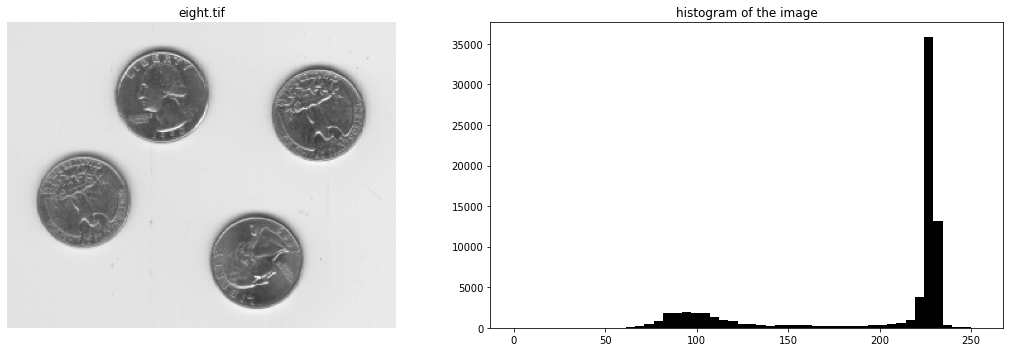

In [2]:
# read test image
eight = io.imread('eight.tif')

# plot test image and its histogram
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(eight, vmin=0, vmax=255, cmap=plt.get_cmap('gray'))
ax[0].set_title('eight.tif')
ax[0].axis('off')
ax[1].hist(eight.flatten(), range=(0, 255) ,bins=50, fc='black')
ax[1].set_title('histogram of the image')
fig.tight_layout()

As we can see, there is an evident difference in the instensity distribution of pixels belonging to the coins and the background. Therefore, global thresholding is enough for decent segmentation outcome in this case.

The course book introduces the following algorithm for finding a global threshold `T`:
1. Select an initial estimate for `T`. In this exercise, the initial estimate is selected to be the mean gray value of the image to be segmented.
2. Segment the image using threshold `T`. This will produce two groups of pixels: `G1` consists of all pixels with gray level values `>T` and `G2` consisting of pixels with values `<=T`.
3. Compute the average gray level values `u1` and `u2` for the pixels in regions `G1` and `G2`.
4. Compute a new threshold value `T=0.5*(u1+u2)`.
5. Repeat steps 2 through 4 until the difference (NOT remainder) in `T` in successive iterations is smaller than a predefined parameter `T0`. `T0`=1 in this exercise.

**7.1. Now, fill the following template for function `findgraytresh()` so that it performs the algorithm described above. Test your function with the image `eight.tif`. Using the settings given above, you should obtain a threshold of `165.47`. If you do not get this value, there is something wrong with your implementation of the algorithm.**

Hint: Since we are computing a threshold value to an `uint8` image, use the original `[0,255]` value range also when operating on `float64` type images instead of rescaling the pixel values to `[0,1]`!

In [3]:
def findgraytresh(im):
    # define 'T0'
    T0 = 1
    
    # step 1: initialize 'T' as the mean grayscale value in the given image 'im'
    T = np.mean(im)
    T_diff = np.inf
    
    # repeat steps 2-4 until the difference in 'T' in successive iterations is smaller than 'T0=1'
    while T_diff >= T0:
        
        # step 2: segment image using the current estimate of threshold 'T'
        G1 = im[im > T]
        G2 = im[im <= T]
        
        # step 3: compute the mean values 'u1' and 'u2' for the segmented foreground and background pixels
        u1 = np.mean(G1)
        u2 = np.mean(G2)

        # step 4: update threshold value 'T'
        T_old = T
        T = 0.5*(u1+u2)
        T_diff = abs(T_old - T)
        
    # return final estimate of 'T'
    return T

In [4]:
# find the threshold value 'T' for test image using your implementation of 'findgraytresh()' function
T_eight = findgraytresh(eight)

# display the threshold value 'T'
print(T_eight)

165.4703513910725


**7.2. Perform global thresholding to the `eight.tif` image using the threshold value `T` obtained with your implementation of the `findgraythresh()` function and display the segmentation outcome (a binary image).**

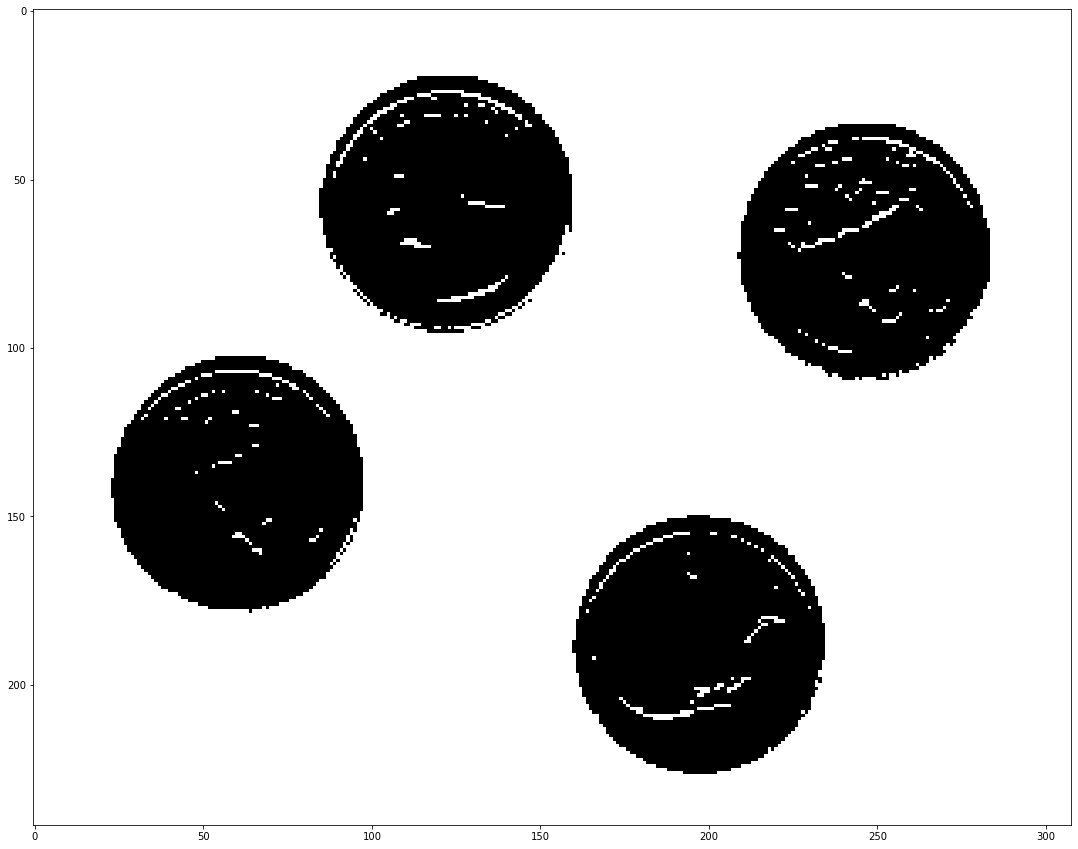

In [5]:
# segment the image
segment_im = eight > T_eight
# display the segmentation result
segmentation = plt.imshow(segment_im)

As you can see, the resulting image contains some unwanted noise (white dots in the coin area). 

**7.3. Use morphological operator(s) erosion and/or dilation and proper structuring element to remove the segmentation noise and display the resulting image.**

Hint: You can use e.g. __[`skimage.morphology`](http://scikit-image.org/docs/dev/api/skimage.morphology.html)__ package.

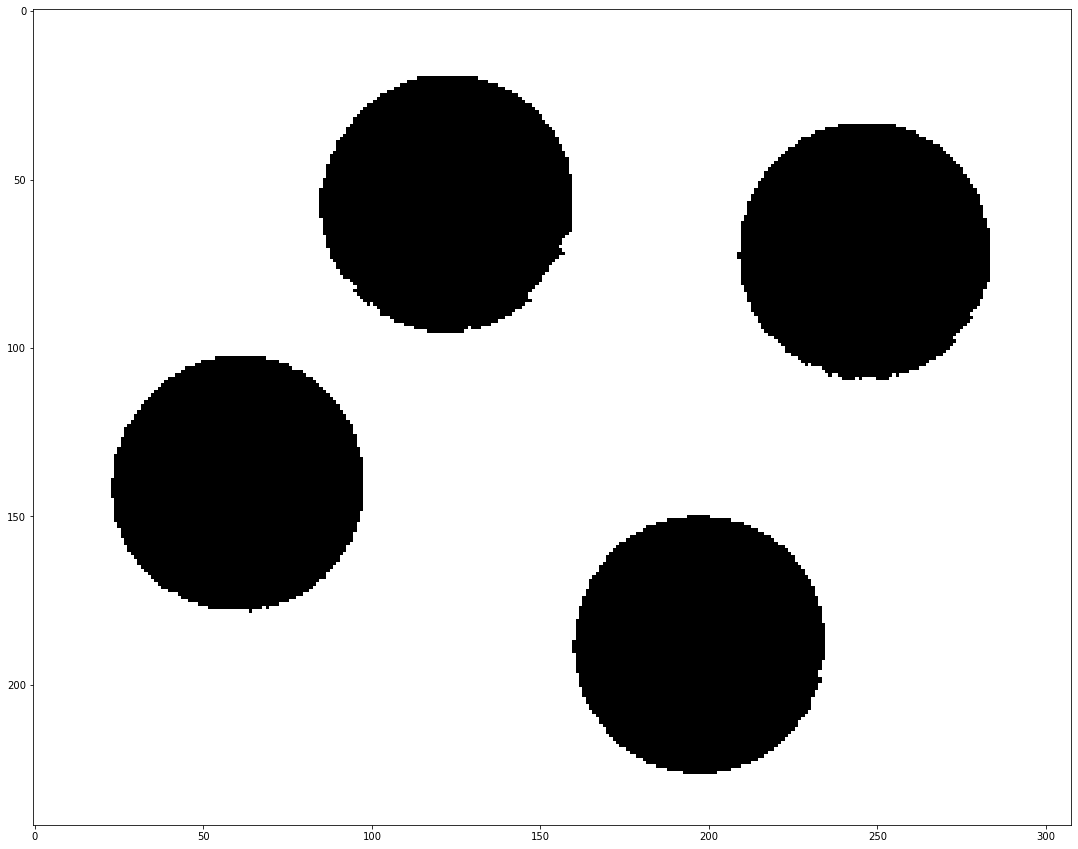

In [6]:
from skimage import morphology
# remove noise in the segmentation result using morphological operators
disk = morphology.disk(2)
#noiseless = morphology.erosion(segment_im, disk)
noiseless = morphology.opening(segment_im, disk)
# display the final segmentation result
plt.imshow(noiseless)

**Which morphological operator(s) did you use?**

`I used erosion-operator and disk-operator.`

**7.4. Now, use morphological boundary extraction (see course book or lecture material) to the binary image to find the pixels belonging to the coin boundaries and superimpose the extracted boundaries on the original `eight.tif` image. Display the boundary image and the original image with superimposed boundaries in the same figure.**

Hint: Assuming that the variable `boundary` contains the result of morphological binary extraction (logical image), the boundaries can be overlaid, e.g. by:

`>>> eight[boundary] = 0`

or with __[`matplotlib.pyplot.contour()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.contour.html)__ function.

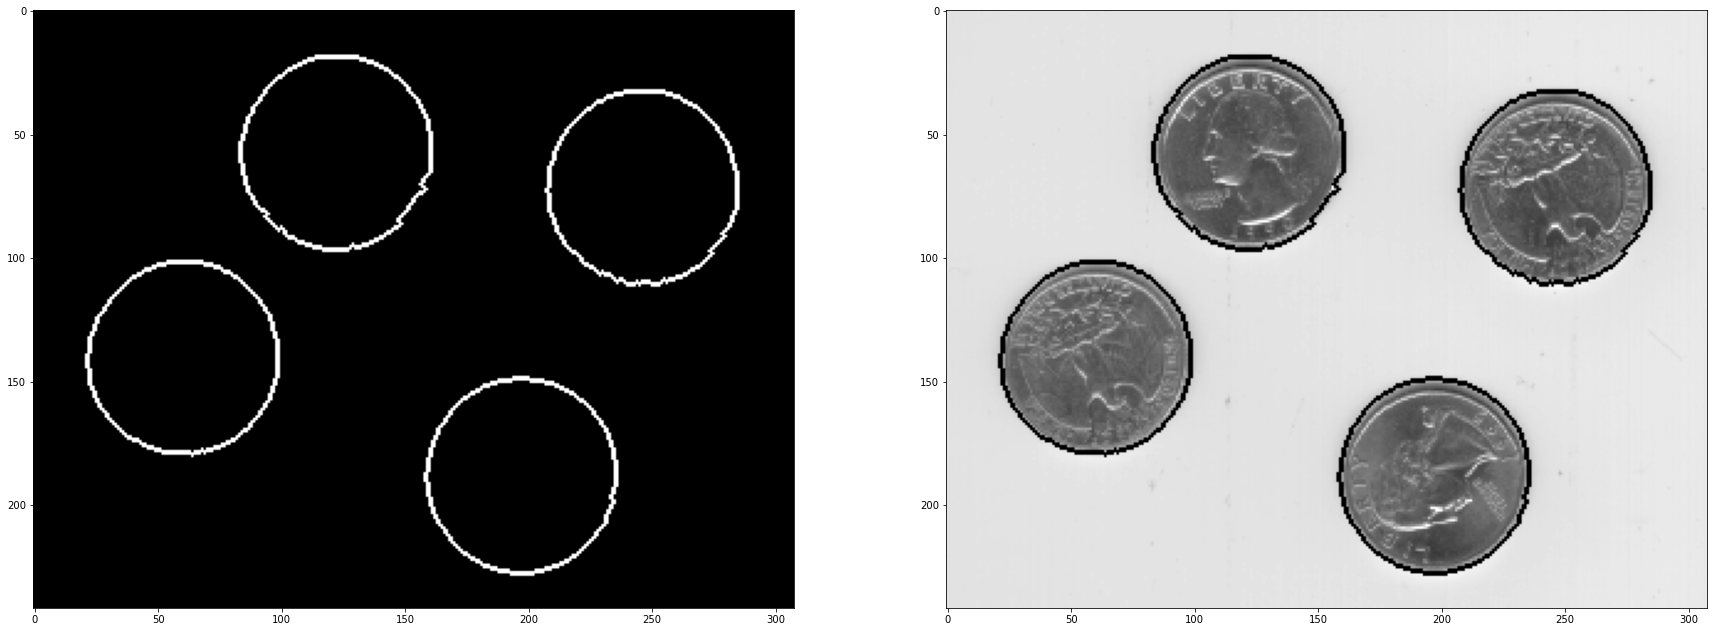

In [7]:
# get coin boundaries using morphological boundary extraction
disk = morphology.disk(2)
boundary = noiseless ^ morphology.erosion(noiseless,disk)
# superimpose coin boundaries on the original test image
eight[boundary] = 0
# display the extracted boundaries and the boundaries overlaid on the original image
plt.subplot(1,2,1)
plt.imshow(boundary)
plt.subplot(1,2,2)
plt.imshow(eight)

# 8. Watersheds

If the acquisition conditions are not optimal or the image is cluttered, global thresholding does not produce acceptable segmentation result. Here we simulate challenging lighting conditions by multiplying the image with a “lighting component”:

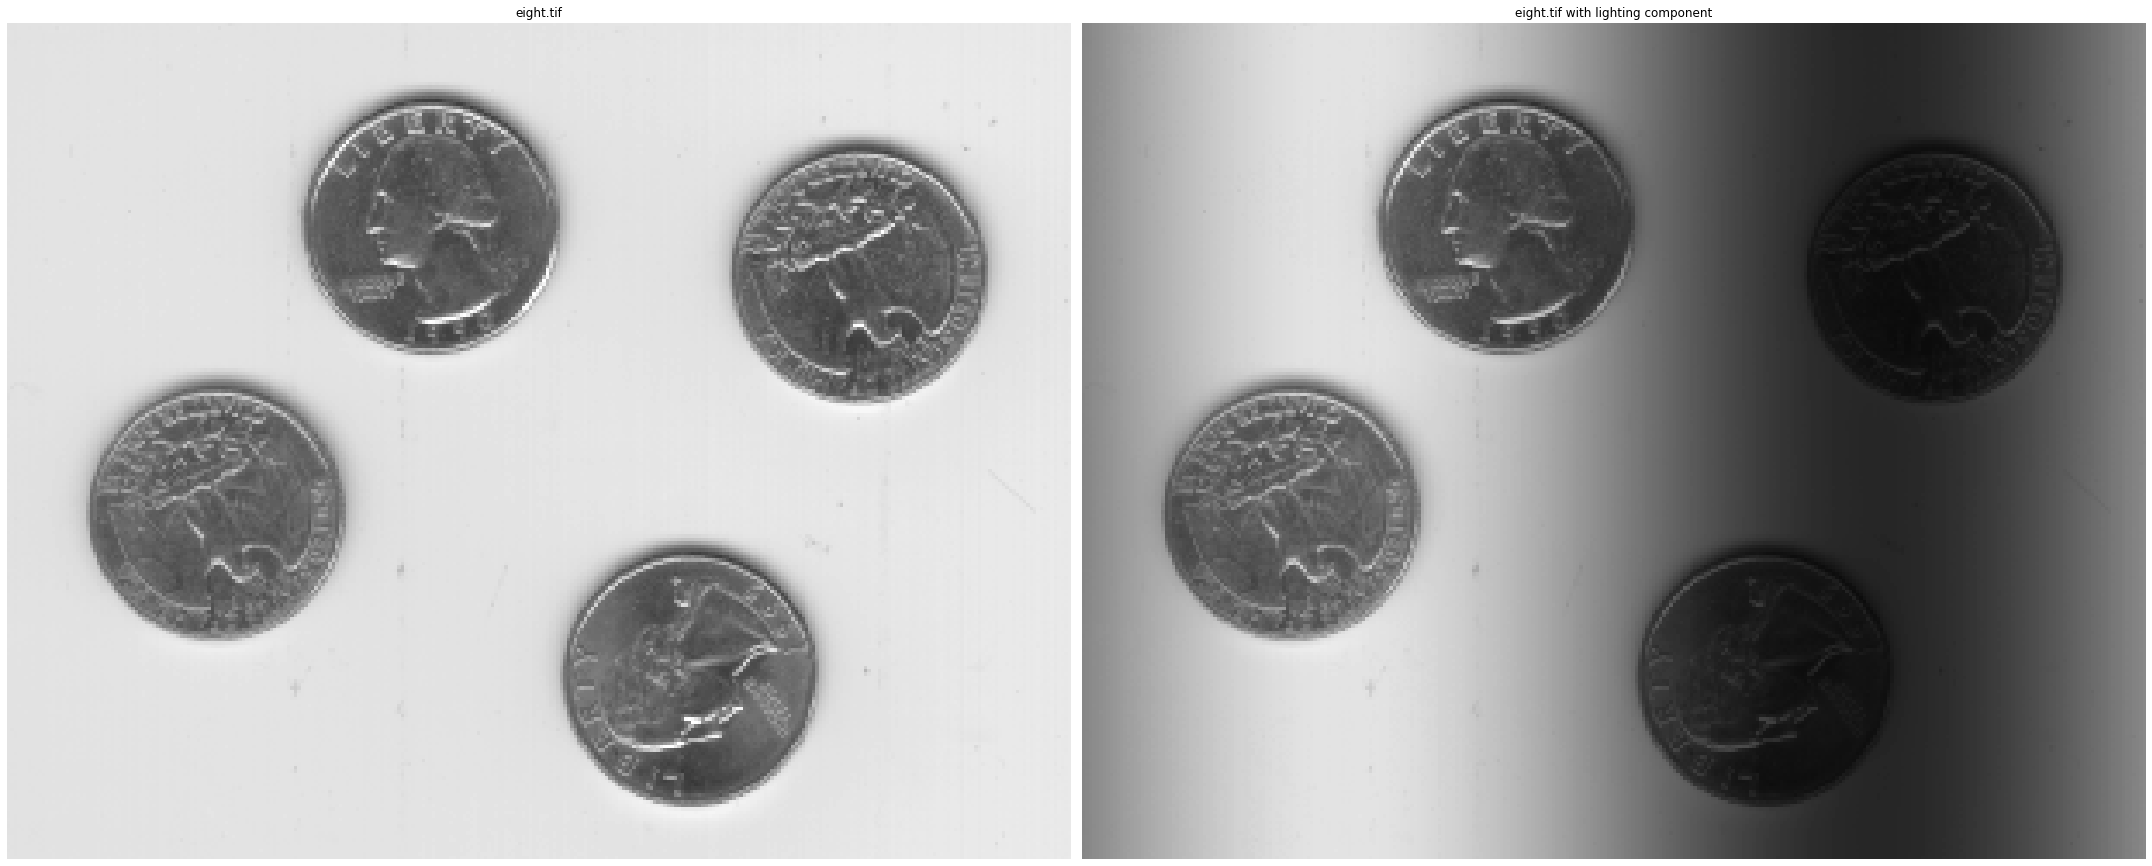

In [8]:
from scipy.io import loadmat

# introduce lighting component to the coin image
eight = io.imread('eight.tif')
light = loadmat('light.mat')['light']
eight2 = eight*light

# display the test image with and without additional lighting component
fig, ax = plt.subplots(1, 2)
ax[0].imshow(eight, vmin=0, vmax=255, cmap=plt.get_cmap('gray'))
ax[0].set_title('eight.tif')
ax[0].axis('off')
ax[1].imshow(eight2, vmin=0, vmax=255, cmap=plt.get_cmap('gray'))
ax[1].set_title('eight.tif with lighting component')
ax[1].axis('off')
fig.tight_layout()

**8.1. The resulting image cannot be probably segmented with the simple global thresholding method that you implemented in the previous task (`7.1`). Try, what happens and display the segmentation outcome and the histogram of the `eight2` image.**

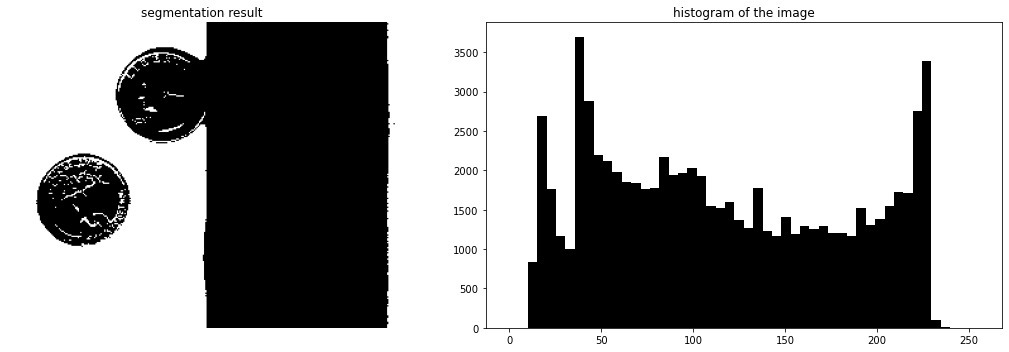

In [9]:
# find global threshold for the 'eight2' image using 'findgraytresh()' function
threshold2 = findgraytresh(eight2)

# segment the 'eight2' image using the obtained threshold value
segm_eight2 = eight2 > threshold2

# display the segmentation result and the histogram of the test image 'eight2'
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(segm_eight2)
ax[0].set_title('segmentation result')
ax[0].axis('off')
ax[1].hist(eight2.flatten(), range=(0, 255) ,bins=50, fc='black')
ax[1].set_title('histogram of the image')
fig.tight_layout()

**Explain why the simple global thresholding based segmentation method fails.**

`Simple global threshlding method fails because it cannot detect the shadow on the right side of image to have both coins and background. So global thresholding thinks all of the right side is part of the coins and not the background.`

Instead, one can apply more advanced image segmentation algorithms, like watershed segmentation that we will use in the following task. First, read the part concerning watersheds in the lecture material.

**8.2. Now, compute the gradient magnitude of the `eight2` image using Sobel mask. Then, display the image `eight2` and the gradient magnitude image in the same figure.**

Hint: Compute first the horizontal and vertical gradient images, and then compute the gradient magnitude. You can use __[`scipy.ndimage.sobel()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html#scipy.ndimage.sobel)__ function for computing the horizontal and vertical gradient images (`axis` parameter defines the direction of the gradient).

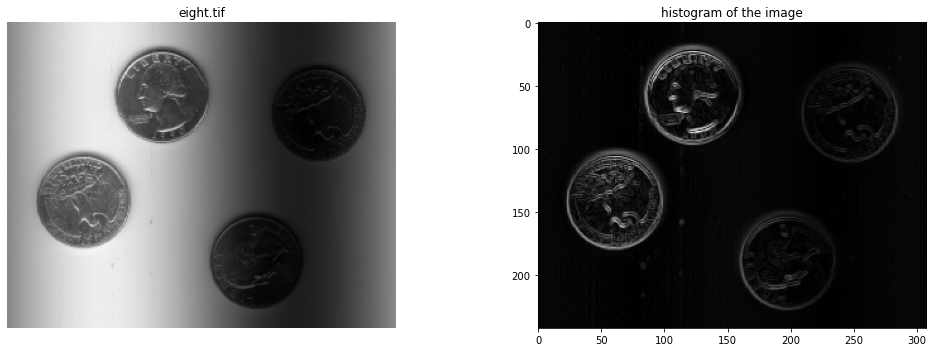

In [10]:
from scipy import ndimage
# compute horizontal gradient using Sobel mask
horizontal = ndimage.sobel(eight2, axis=0) #scipy-lectures
# compute vertical gradient using Sobel mask
vertical = ndimage.sobel(eight2, axis=1) #scipy-lectures
# compute gradient magnitude 
magnitude = np.sqrt(horizontal**2+vertical**2)

# plot test image and its gradient magnitude image
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(eight2)
ax[0].set_title('eight.tif')
ax[0].axis('off')
ax[1].imshow(magnitude)
ax[1].set_title('histogram of the image')
fig.tight_layout()

Next, we need to create a marker image that introduces few seed pixels that are certain to belong into foreground objects and background. First, we introduce internal markers, i.e. pixels belonging to each coin:

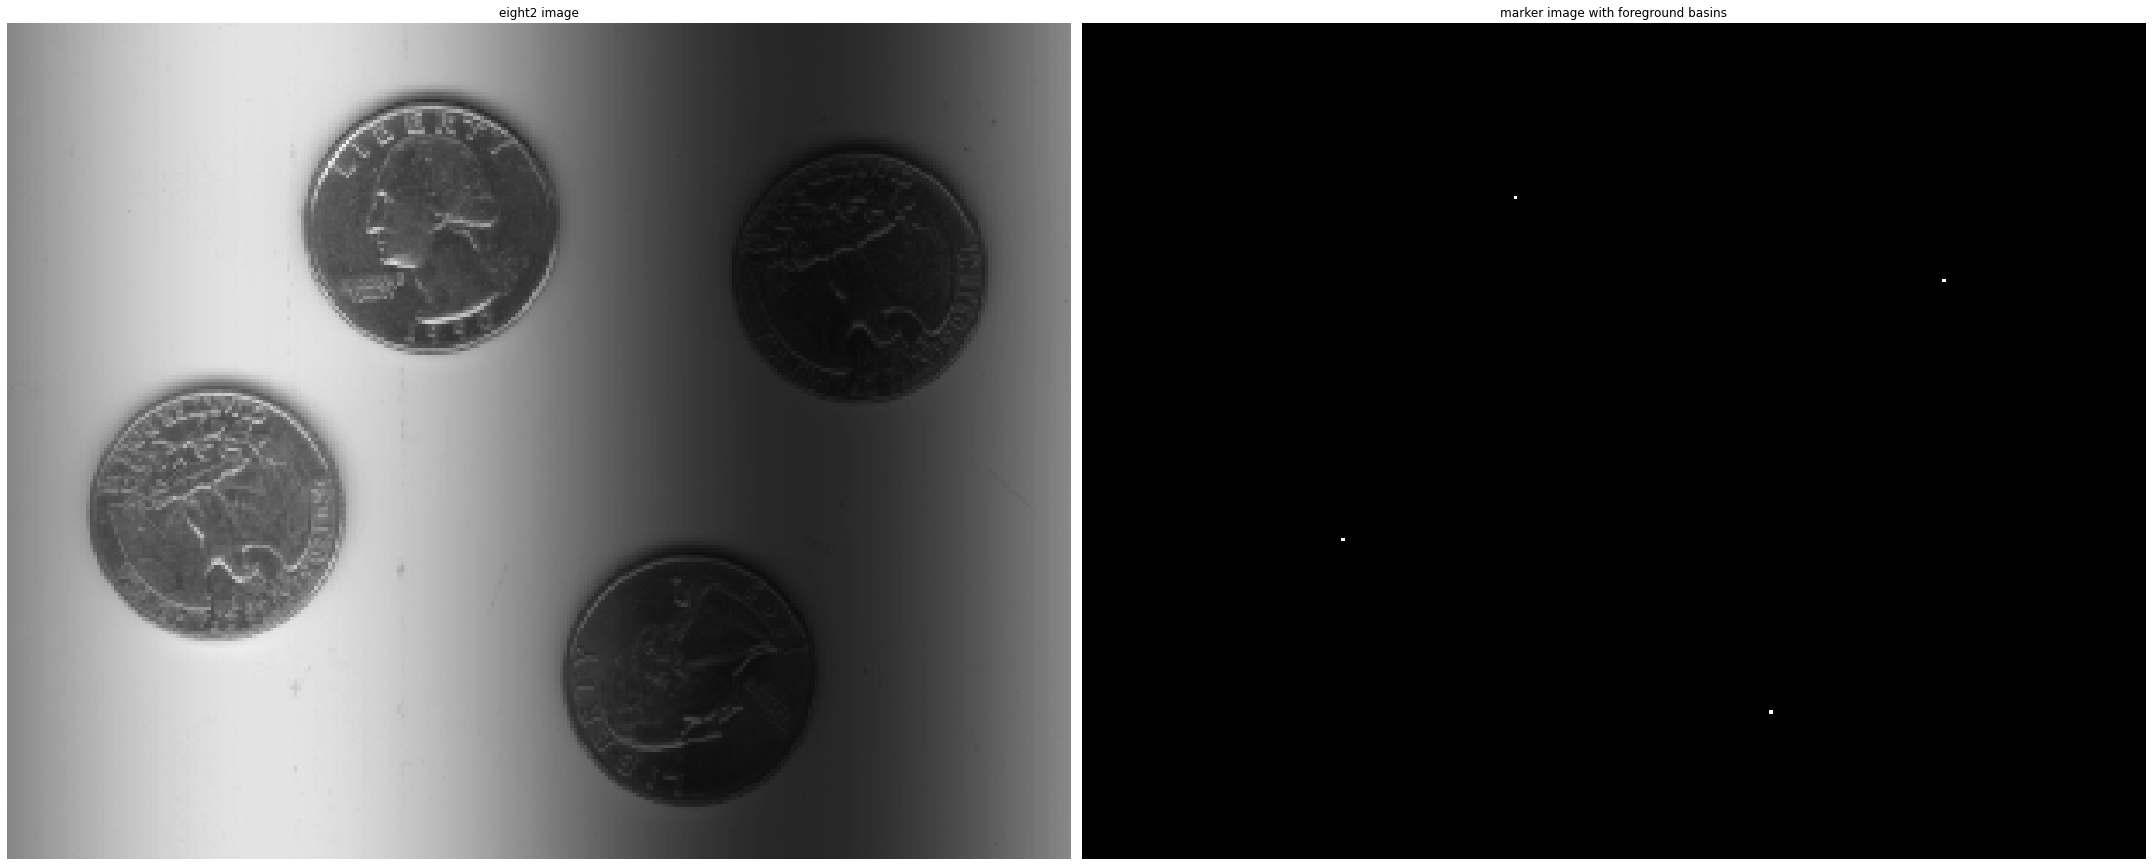

In [11]:
# create marker image, i.e. create a set of basins that are certain to belong into foreground objects
markers = np.zeros_like(eight2)
markers[50,125]  = 1
markers[149,75]  = 1
markers[74,249]  = 1
markers[199,199] = 1

markers_internal = np.copy(markers)

# plot gradient image
fig, ax = plt.subplots(1,2)
ax[0].imshow(eight2, vmin=0, vmax=255, cmap=plt.get_cmap('gray'))
ax[0].set_title('eight2 image')
ax[0].axis('off')
ax[1].imshow(markers, cmap=plt.get_cmap('gray'))
ax[1].set_title('marker image with foreground basins')
ax[1].axis('off')
fig.tight_layout()

Note that the set of internal markers can also be obtained automatically using, e.g. texture, size or shape of the objects but here we placed the markers by hand for the sake of simplicity.

We also need external markers that are certain to belong to background. Here we choose to mark to background some pixels that lie exactly midway between internal markers. This is can be done by computing the distance transform between the internal markers and by finding dense set of local maxima from the resulting distance map:

C:\Users\saara\AppData\Local\Temp/ipykernel_7288/1709728934.py:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance_map, indices=False, min_distance=1)


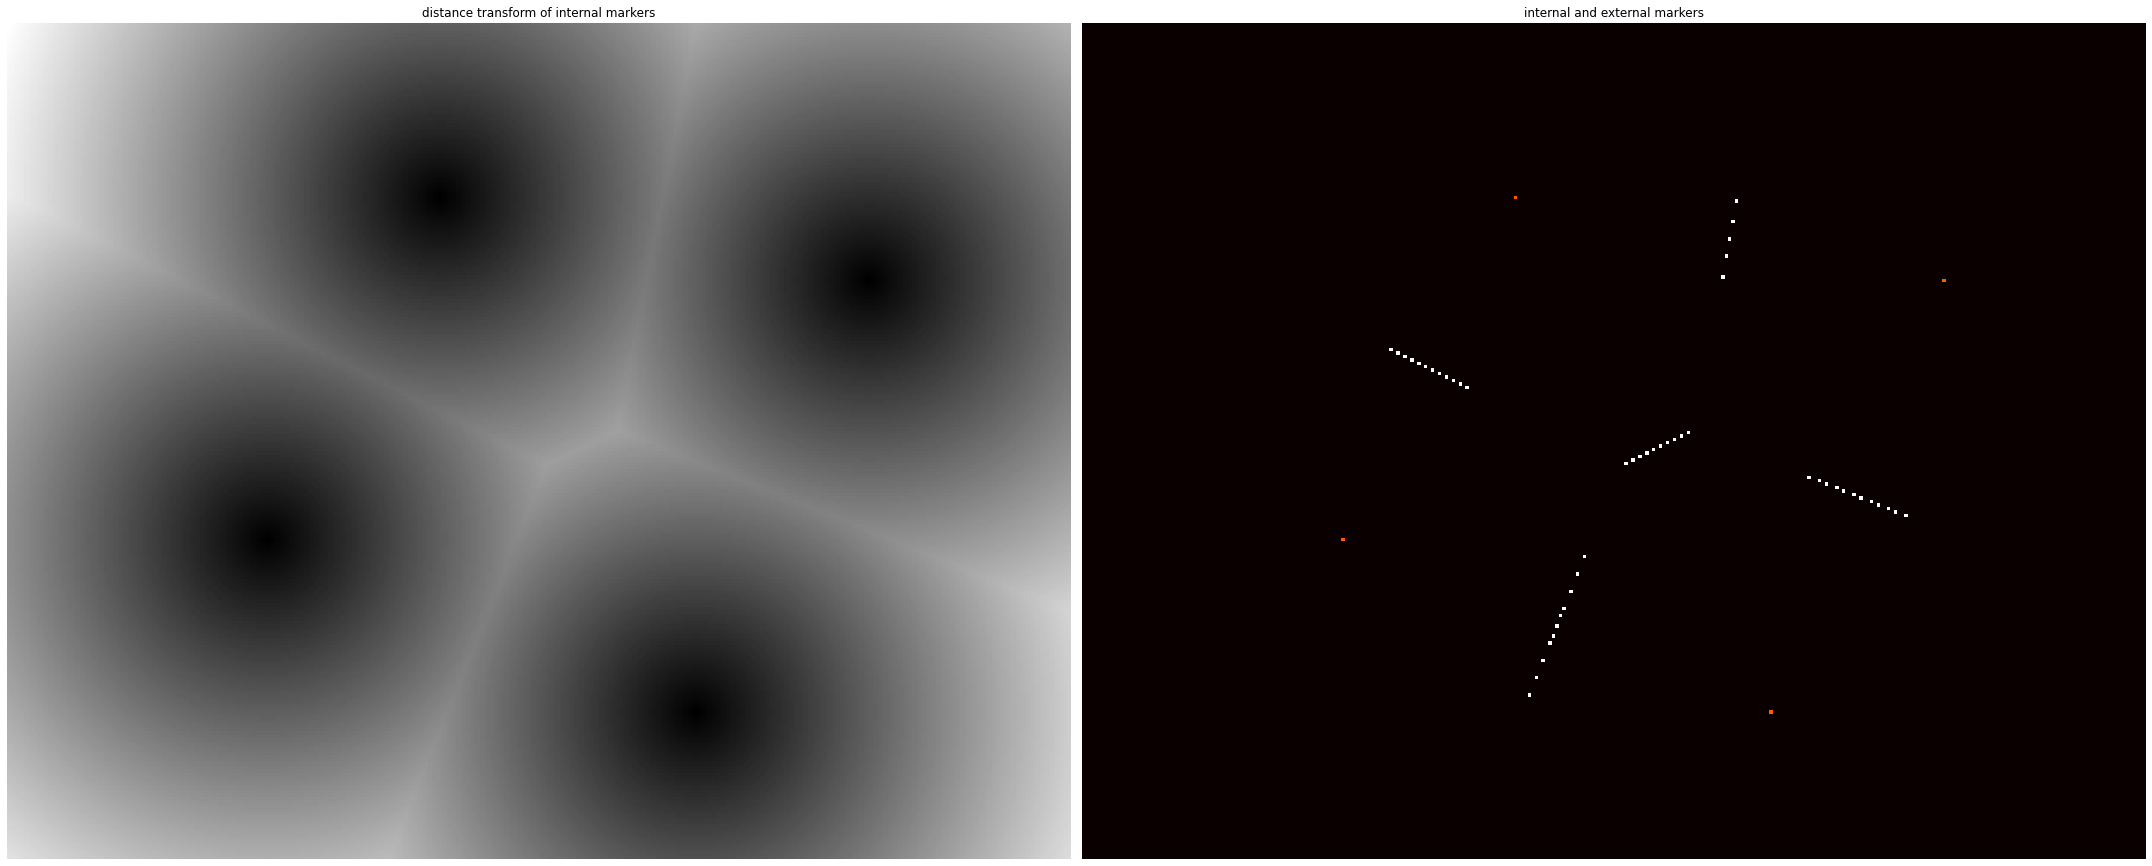

In [12]:
from skimage.feature import peak_local_max

# compute distance transform for each white pixel
distance_map = ndimage.distance_transform_edt(np.logical_not(markers_internal))

# find local peaks in the distance map
local_maxi = peak_local_max(distance_map, indices=False, min_distance=1)

# set external markers to the marker image 
markers[local_maxi] = 2

# display distance transform image and marker image with internal and external markers
fig, ax = plt.subplots(1, 2)
ax[0].imshow(distance_map, cmap=plt.get_cmap('gray'))
ax[0].set_title('distance transform of internal markers')
ax[0].axis('off')
ax[1].imshow(markers, cmap=plt.get_cmap('hot'))
ax[1].axis('off')
ax[1].set_title('internal and external markers')
fig.tight_layout()

Every pixel value in the distance transform image tells the distance of a pixel to the closest internal marker (in pixels). The white pixels correspond to external markers and the red pixels to internal markers in marker image.

**8.3. Now, apply watershed segmentation with function __[`skimage.morphology.watershed()`](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed)__ on the gradient magnitude image using the defined markers and display the segmentation result.**

Hint: Please note the output type of the function, which is a labeled matrix of the same type and shape as markers!

C:\Users\saara\anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


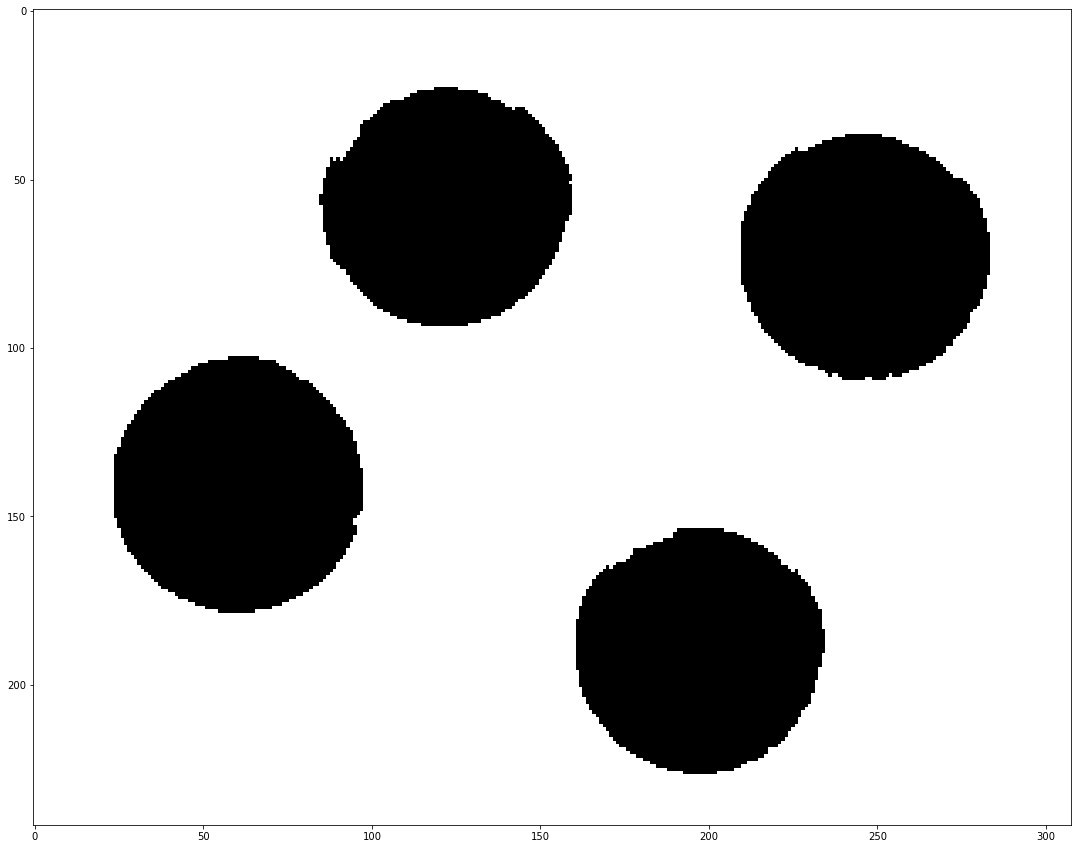

In [13]:
# apply watershed segmentation on the gradient magnitude image with the markers (image) defined above
img_watershed = morphology.watershed(magnitude, markers)
img_watershed.astype(np.uint8)
# display the segmentation result
plt.imshow(img_watershed)

**8.4. Finally, apply morphological boundary extraction on the segmentation result and superimpose the boundaries on the original `eight2` image like in 7.4.**

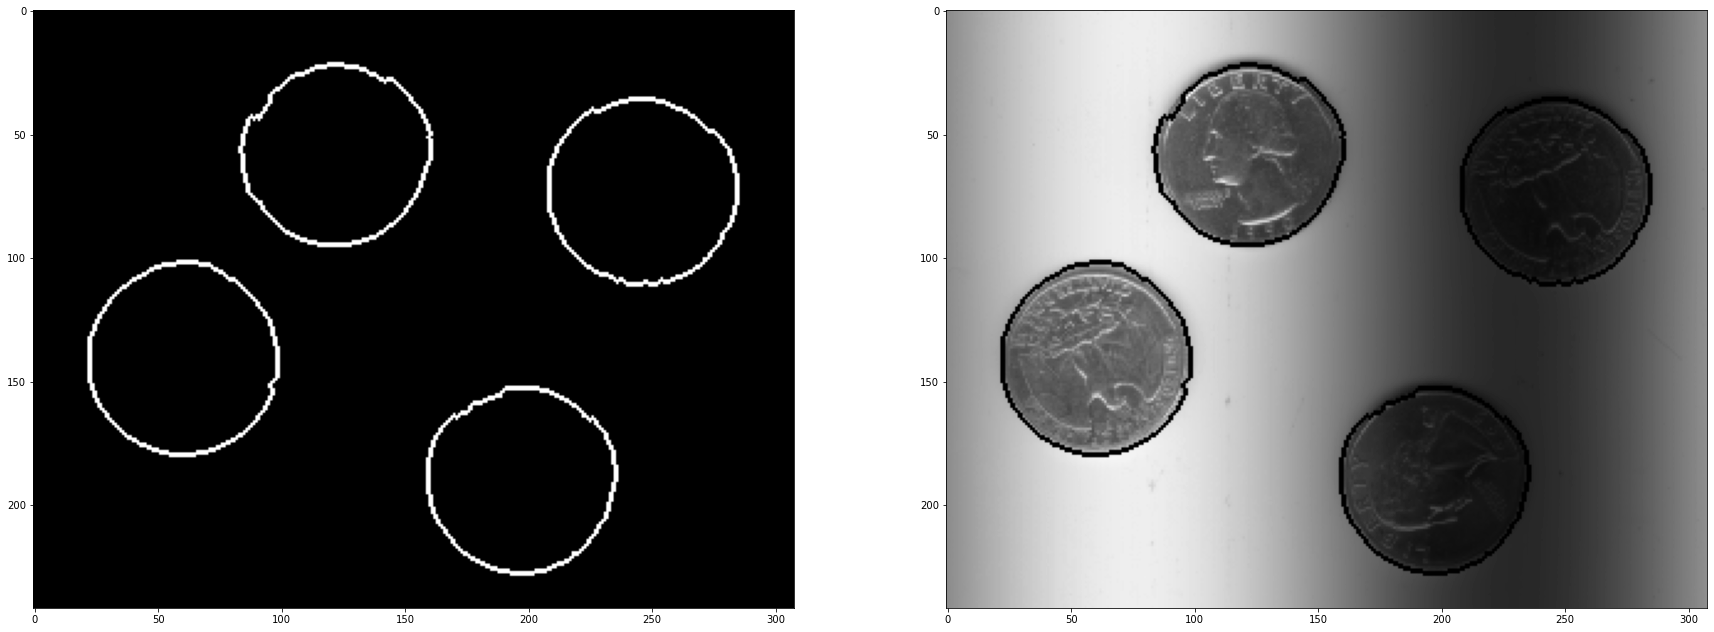

In [14]:
# perform morphological boundary extraction
disk1 = morphology.disk(2)
boundaries = img_watershed > morphology.erosion(img_watershed,disk)
plt.subplot(121)
plt.imshow(boundaries)

# superimpose the extracted contours on the original test image
eight2[boundaries] = 0

# display the test image overlaid segmentation result
plt.subplot(122)
plt.imshow(eight2)

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`This exercise took me 2 h 21 min.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`I had lot of problems with this exercise but I got lot of help from the assistant and found help from Google or from the lecture materials.`

# References
`On 8.2 I used scipy lectures to figure out how to use the sobel. (https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_find_edges.html)`

# Submission

1. Before submitting your work, **check that your notebook (code) runs from scratch** and reproduces all the requested results by clicking on the menu `Kernel -> Restart & Run All`! Also, check that you have answered all the questions written in **bold**.
2. Clear all outputs and variables, etc. by click on the menu `Kernel -> Restart & Clear Output`. This may (or will) reduce the file size of your deliverable a lot! 
3. Rename this Jupyter notebook to **`DIP_PA5_[student number(s)].ipynb`** (e.g. `DIP_PA5_1234567.ipynb` if solo work or `DIP_PA5_1234567-7654321.ipynb` if pair work) and upload it as your submission to Moodle.